### Data sources
- LEHD Origin-Destination Employment Statistics (LODES): The definition of variable codes, datasets, etc. can be found at the latest [LODES 7.3 Technical Documentation](https://lehd.ces.census.gov/data/lodes/LODES7/LODESTechDoc7.3.pdf). All LEHD Origin-Destination Employment Statistics (LODES) data are available, as described in the LODES documentation above. No changes have been made to the original CSV files. Data are available from 2002 to 2015. See the documentation above for caveats.
- Driving Times and Distances Dataset: Census tracts are 2010 vintage, and the columns are the origin tract, destination travel, travel time in minutes, and travel distance in miles. These data were calculated by the Data Science team at the Urban Institute. See [Github repo](https://github.com/UI-Research/spark-osrm).

In [1]:
import pyspark
import numpy as np
import pandas as pd
from pyspark.sql.functions import *
from pyspark.sql.window import Window
from pyspark.ml.linalg import Vectors
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator 

from IPython.core.interactiveshell import InteractiveShell
from pyspark.sql.types import StringType

warnings.filterwarnings(action='once')
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

In [2]:
sc._conf.getAll() 

[(u'spark.driver.appUIAddress',
  u'http://ip-172-31-43-229.us-east-2.compute.internal:4040'),
 (u'spark.blacklist.decommissioning.enabled', u'true'),
 (u'spark.eventLog.enabled', u'true'),
 (u'spark.driver.extraLibraryPath',
  u'/usr/lib/hadoop/lib/native:/usr/lib/hadoop-lzo/lib/native'),
 (u'spark.blacklist.decommissioning.timeout', u'1h'),
 (u'spark.yarn.appMasterEnv.SPARK_PUBLIC_DNS', u'$(hostname -f)'),
 (u'spark.jars.packages', u''),
 (u'spark.executor.cores', u'4'),
 (u'spark.executor.extraJavaOptions',
  u"-verbose:gc -XX:+PrintGCDetails -XX:+PrintGCDateStamps -XX:+UseConcMarkSweepGC -XX:CMSInitiatingOccupancyFraction=70 -XX:MaxHeapFreeRatio=70 -XX:+CMSClassUnloadingEnabled -XX:OnOutOfMemoryError='kill -9 %p'"),
 (u'spark.eventLog.dir', u'hdfs:///var/log/spark/apps'),
 (u'spark.app.id', u'application_1520019965821_0007'),
 (u'spark.sql.hive.metastore.sharedPrefixes',
  u'com.amazonaws.services.dynamodbv2'),
 (u'spark.sql.warehouse.dir', u'hdfs:///user/spark/warehouse'),
 (u'spa

In [2]:
# reasonable tuning parameters for 8 worker nodes with 16gb and 4 cores each
spark = SparkSession.builder \
    .appName('pyspark-exploration') \
    .config('spark.driver.cores', '4') \
    .config('spark.executor.memory', '16gb') \
    .config('spark.executor.cores', '4') \
    .getOrCreate()     

In [3]:
def debug(df):
    """
    Function to pretty print the toDebugString
    """
    for rddstring in df.rdd.toDebugString().split('\n'):
        print rddstring.strip()

### Load and prepare data

Load in data and see what it looks like. We will be focusing on origin-destination (OD), residential area characteristics (RAC), and driving time/distance (drive)

In [4]:
drive = spark.read.parquet('s3://lsdm-emr-util/lsdm-data/travel-times/drive_times.parquet')
od = spark.read.parquet('s3://lsdm-emr-util/lsdm-data/lodes/od/od.parquet')
rac = spark.read.parquet('s3://lsdm-emr-util/lsdm-data/lodes/rac/rac.parquet')

In [5]:
print((drive.count(), len(drive.columns)))
drive.take(2)
drive.dtypes

(122004331, 4)


[Row(from_tract=u'36103146402', to_tract=u'42091207003', miles=141.2, minutes=184.1),
 Row(from_tract=u'36103146402', to_tract=u'42091209000', miles=162.7, minutes=203.4)]

[('from_tract', 'string'),
 ('to_tract', 'string'),
 ('miles', 'double'),
 ('minutes', 'double')]

In [6]:
print((od.count(), len(od.columns)))
od.take(2)
od.dtypes

(1577789908, 14)


[Row(w_geocode=u'271630714002025', h_geocode=u'271630712082020', s000=1, sa01=0, sa02=1, sa03=0, se01=0, se02=1, se03=0, si01=1, si02=0, si03=0, createdate=u'20160219', year=2012),
 Row(w_geocode=u'271630714002025', h_geocode=u'271630712083004', s000=1, sa01=0, sa02=1, sa03=0, se01=0, se02=1, se03=0, si01=1, si02=0, si03=0, createdate=u'20160219', year=2012)]

[('w_geocode', 'string'),
 ('h_geocode', 'string'),
 ('s000', 'int'),
 ('sa01', 'int'),
 ('sa02', 'int'),
 ('sa03', 'int'),
 ('se01', 'int'),
 ('se02', 'int'),
 ('se03', 'int'),
 ('si01', 'int'),
 ('si02', 'int'),
 ('si03', 'int'),
 ('createdate', 'string'),
 ('year', 'int')]

In [7]:
print((rac.count(), len(rac.columns)))
rac.take(2)
rac.dtypes

(80870134, 44)


[Row(h_geocode=u'480019501001000', c000=12, ca01=4, ca02=6, ca03=2, ce01=4, ce02=5, ce03=3, cns01=0, cns02=1, cns03=0, cns04=0, cns05=1, cns06=2, cns07=2, cns08=0, cns09=0, cns10=0, cns11=1, cns12=0, cns13=0, cns14=0, cns15=1, cns16=2, cns17=0, cns18=2, cns19=0, cns20=0, cr01=10, cr02=2, cr03=0, cr04=0, cr05=0, cr07=0, ct01=8, ct02=4, cd01=1, cd02=3, cd03=1, cd04=3, cs01=8, cs02=4, createdate=u'20170919', year=2015),
 Row(h_geocode=u'480019501001001', c000=56, ca01=9, ca02=27, ca03=20, ce01=13, ce02=22, ce03=21, cns01=0, cns02=1, cns03=1, cns04=5, cns05=3, cns06=2, cns07=6, cns08=3, cns09=3, cns10=3, cns11=0, cns12=2, cns13=0, cns14=1, cns15=5, cns16=10, cns17=1, cns18=3, cns19=2, cns20=5, cr01=45, cr02=6, cr03=0, cr04=4, cr05=0, cr07=1, ct01=51, ct02=5, cd01=3, cd02=10, cd03=19, cd04=15, cs01=28, cs02=28, createdate=u'20170919', year=2015)]

[('h_geocode', 'string'),
 ('c000', 'int'),
 ('ca01', 'int'),
 ('ca02', 'int'),
 ('ca03', 'int'),
 ('ce01', 'int'),
 ('ce02', 'int'),
 ('ce03', 'int'),
 ('cns01', 'int'),
 ('cns02', 'int'),
 ('cns03', 'int'),
 ('cns04', 'int'),
 ('cns05', 'int'),
 ('cns06', 'int'),
 ('cns07', 'int'),
 ('cns08', 'int'),
 ('cns09', 'int'),
 ('cns10', 'int'),
 ('cns11', 'int'),
 ('cns12', 'int'),
 ('cns13', 'int'),
 ('cns14', 'int'),
 ('cns15', 'int'),
 ('cns16', 'int'),
 ('cns17', 'int'),
 ('cns18', 'int'),
 ('cns19', 'int'),
 ('cns20', 'int'),
 ('cr01', 'int'),
 ('cr02', 'int'),
 ('cr03', 'int'),
 ('cr04', 'int'),
 ('cr05', 'int'),
 ('cr07', 'int'),
 ('ct01', 'int'),
 ('ct02', 'int'),
 ('cd01', 'int'),
 ('cd02', 'int'),
 ('cd03', 'int'),
 ('cd04', 'int'),
 ('cs01', 'int'),
 ('cs02', 'int'),
 ('createdate', 'string'),
 ('year', 'int')]

Make census tract and state columns in origin-destination and residential data

In [8]:
od = od.withColumn('h_tract', substring(od.h_geocode, 0, 11))\
        .withColumn('w_tract', substring(od.w_geocode, 0, 11))\
        .withColumn('h_state', substring(od.h_geocode, 0, 2))\
        .withColumn('w_state', substring(od.w_geocode, 0, 2))

In [9]:
rac = rac.withColumn('h_tract', substring(rac.h_geocode, 0, 11))\
        .withColumn('h_state', substring(rac.h_geocode, 0, 2))

Make state column in drive data

In [10]:
drive = drive.withColumn('from_state', substring(drive.from_tract, 0, 2))\
            .withColumn('to_state', substring(drive.to_tract, 0, 2))

Make "total" and "pct" columns

In [11]:
sa_cols = ['sa01', 'sa02', 'sa03']
se_cols = ['se01', 'se02', 'se03']
si_cols = ['si01', 'si02', 'si03']

In [12]:
od = od.withColumn('sa_total', od.sa01+od.sa02+od.sa03)\
    .withColumn('se_total', od.se01+od.se02+od.se03)\
    .withColumn('si_total', od.si01+od.si02+od.si03)

In [13]:
for cat_ls, cat_name in [(sa_cols, 'sa_total'), (se_cols, 'se_total'), (si_cols, 'si_total')]:
    for col in cat_ls:
        new = col + '_pct'
        od = od.withColumn(new, od[col]/od[cat_name])

Check out lineage and partitions of the two dataframes

In [15]:
debug(od)

(137) MapPartitionsRDD[36] at javaToPython at NativeMethodAccessorImpl.java:0 []
|   MapPartitionsRDD[35] at javaToPython at NativeMethodAccessorImpl.java:0 []
|   MapPartitionsRDD[34] at javaToPython at NativeMethodAccessorImpl.java:0 []
|   FileScanRDD[33] at javaToPython at NativeMethodAccessorImpl.java:0 []


In [16]:
debug(drive)

(57) MapPartitionsRDD[40] at javaToPython at NativeMethodAccessorImpl.java:0 []
|   MapPartitionsRDD[39] at javaToPython at NativeMethodAccessorImpl.java:0 []
|   MapPartitionsRDD[38] at javaToPython at NativeMethodAccessorImpl.java:0 []
|   FileScanRDD[37] at javaToPython at NativeMethodAccessorImpl.java:0 []


In [17]:
od.rdd.getNumPartitions()
drive.rdd.getNumPartitions()

137

57

### Join: origin-destination and driving dataframes  
Assumption: travel time and distance for a census tract is the same for all its comprising block groups.

Execution explanation:  
Storage level = Serialized 1x Replicated  
This join involved one job: 3 stages, 195 tasks, 16 executors running


Try working with just California data first, where origin and destination are state code 06  
Join od_ca and drive_ca

In [14]:
od_ca = od.where("h_state == 06" and "w_state == 06")

In [15]:
drive_ca = drive.where('to_state == 06' and 'from_state == 06')

In [16]:
df_ca = od_ca.join(drive_ca, [drive.from_tract == od.h_tract, drive.to_tract == od.w_tract])

Now join full od with driving, giving us travel times for each origin-destination pair.  

In [17]:
df = od.join(drive, [drive.from_tract == od.h_tract, drive.to_tract == od.w_tract])

Resulting merged dataframe is split across 200 partitions, as we can see from the getNumPartitions method

In [23]:
df.rdd.getNumPartitions()

200

In [68]:
print(df.rdd.getStorageLevel())

Serialized 1x Replicated


In [24]:
debug(df)

(200) MapPartitionsRDD[54] at javaToPython at NativeMethodAccessorImpl.java:0 []
|   MapPartitionsRDD[53] at javaToPython at NativeMethodAccessorImpl.java:0 []
|   MapPartitionsRDD[52] at javaToPython at NativeMethodAccessorImpl.java:0 []
|   ZippedPartitionsRDD2[51] at javaToPython at NativeMethodAccessorImpl.java:0 []
|   MapPartitionsRDD[45] at javaToPython at NativeMethodAccessorImpl.java:0 []
|   ShuffledRowRDD[44] at javaToPython at NativeMethodAccessorImpl.java:0 []
+-(137) MapPartitionsRDD[43] at javaToPython at NativeMethodAccessorImpl.java:0 []
|   MapPartitionsRDD[42] at javaToPython at NativeMethodAccessorImpl.java:0 []
|   FileScanRDD[41] at javaToPython at NativeMethodAccessorImpl.java:0 []
|   MapPartitionsRDD[50] at javaToPython at NativeMethodAccessorImpl.java:0 []
|   ShuffledRowRDD[49] at javaToPython at NativeMethodAccessorImpl.java:0 []
+-(57) MapPartitionsRDD[48] at javaToPython at NativeMethodAccessorImpl.java:0 []
|   MapPartitionsRDD[47] at javaToPython at Nati

In [25]:
df.take(1)

[Row(w_geocode=u'010830208013001', h_geocode=u'010010201002025', s000=1, sa01=0, sa02=1, sa03=0, se01=0, se02=0, se03=1, si01=0, si02=0, si03=1, createdate=u'20160229', year=2010, h_tract=u'01001020100', w_tract=u'01083020801', h_state=u'01', w_state=u'01', sa_total=1, se_total=1, si_total=1, sa01_pct=0.0, sa02_pct=1.0, sa03_pct=0.0, se01_pct=0.0, se02_pct=0.0, se03_pct=1.0, si01_pct=0.0, si02_pct=0.0, si03_pct=1.0, from_tract=u'01001020100', to_tract=u'01083020801', miles=181.5, minutes=215.9, from_state=u'01', to_state=u'01')]

### Grouped aggregation: proportion of goods-producing jobs per year

Again, start with California only  

The proportion of jobs in California in Goods Producing industry sectors ("si01") has steadily declined over the past decade as the economy moved away from manufacturing jobs. Goods Producing industry sector jobs used to make up ~20% of all jobs; now they make up 15%.


Execution explanation:  
Storage level = Serialized 1x Replicated  
This aggregation involved one job: 4 stages, 594 tasks, 16 executors running


In [26]:
agg_ca = df_ca.groupBy("year").agg(sum("si01"), sum('si02'), sum('si03'))
results_ca = agg_ca.collect()

In [71]:
print(agg_ca.rdd.getStorageLevel())

Serialized 1x Replicated


In [27]:
agg_ca_df = pd.DataFrame(results_ca)

In [28]:
agg_ca_df.columns = ['year', 'si01', 'si02', 'si03']
agg_ca_df['total_jobs'] = agg_ca_df.si01 + agg_ca_df.si02 + agg_ca_df.si03

In [29]:
agg_ca_df['pct_si01'] = agg_ca_df.si01 / agg_ca_df.total_jobs

In [30]:
agg_ca_df.sort_values('year')

,year,si01,si02,si03,total_jobs,pct_si01
13,2002,1061707,1033147,3245012,5339866,0.198827
0,2003,1019401,1024673,3263365,5307439,0.192070
6,2004,1028667,1022742,3306224,5357633,0.192000
9,2005,1052749,1053289,3372850,5478888,0.192146
3,2006,1045599,1071275,3441228,5558102,0.188122
1,2007,1025099,1065219,3474935,5565253,0.184196
12,2008,967440,1052308,3553468,5573216,0.173587
8,2009,877083,977576,3534286,5388945,0.162756
10,2010,823689,978019,3610732,5412440,0.152184
11,2011,827560,1009758,3651098,5488416,0.150783


Now do it for the whole country. We see a similar pattern of declining percentage of Goods Producing jobs.

In [31]:
agg_full = df.groupBy("year").agg(sum("si01"), sum('si02'), sum('si03'))
results_full = agg_full.collect()

In [32]:
agg_full_df = pd.DataFrame(results_full)

In [33]:
agg_full_df.columns = ['year', 'si01', 'si02', 'si03']
agg_full_df['total_jobs'] = agg_full_df.si01 + agg_full_df.si02 + agg_full_df.si03

In [34]:
agg_full_df['pct_si01'] = agg_full_df.si01 / agg_full_df.total_jobs

In [35]:
agg_full_df.sort_values('year')

,year,si01,si02,si03,total_jobs,pct_si01
13,2002,9049198,9483453,27533384,46066035,0.196440
0,2003,8865886,9600409,27942515,46408810,0.191039
6,2004,9121645,9926406,29220115,48268166,0.188978
9,2005,9300469,10086742,29813064,49200275,0.189033
3,2006,9447083,10167374,30462147,50076604,0.188653
1,2007,9357236,10167600,30749160,50273996,0.186125
12,2008,9023304,10151678,31044813,50219795,0.179676
8,2009,7960944,9624079,30834938,48419961,0.164415
10,2010,7515555,9468287,31314073,48297915,0.155608
11,2011,7827414,9978429,32872199,50678042,0.154454


### Window function:  central moving average

Central moving average = the average between previous year, current year, and next year

Using the RAC dataset, calculate the central moving average number of jobs for each census tract and year  
Aggregating to census tract instead of staying at block group level to get larger number of jobs to work with

Execution explanation:  
Storage level = Serialized 1x Replicated  
This window function involved one job: 3 stages, 465 tasks, 16 executors running

In [36]:
rac_tract = rac.groupBy("h_state", "h_tract", "year").agg(sum("c000").alias('c000'))

In [70]:
print(rac_tract.rdd.getStorageLevel())

Serialized 1x Replicated


In [37]:
window = Window.partitionBy("h_state", "h_tract")\
            .orderBy("year")\
            .rowsBetween(Window.currentRow -1, Window.currentRow + 1)
avg_jobs = avg('c000').over(window)

In [38]:
rac_tract_avg = rac_tract.select('year', 'h_state', 'h_tract', avg_jobs.alias("central_avg_jobs"))\
                    .orderBy('h_tract', 'year')

In [39]:
rac_tract_avg.limit(15).show()

+----+-------+-----------+-----------------+
|year|h_state|    h_tract| central_avg_jobs|
+----+-------+-----------+-----------------+
|2002|     01|01001020100|            812.0|
|2003|     01|01001020100|            803.0|
|2004|     01|01001020100|796.3333333333334|
|2005|     01|01001020100|825.3333333333334|
|2006|     01|01001020100|865.6666666666666|
|2007|     01|01001020100|913.3333333333334|
|2008|     01|01001020100|            910.0|
|2009|     01|01001020100|877.3333333333334|
|2010|     01|01001020100|822.6666666666666|
|2011|     01|01001020100|            768.0|
|2012|     01|01001020100|737.3333333333334|
|2013|     01|01001020100|739.3333333333334|
|2014|     01|01001020100|769.3333333333334|
|2015|     01|01001020100|            796.0|
|2002|     01|01001020200|            798.5|
+----+-------+-----------+-----------------+



Now do the same window function at the state level

In [40]:
rac_state = rac.groupBy("h_state", "year").agg(sum("c000").alias('c000'))

In [41]:
window = Window.partitionBy("h_state")\
            .orderBy("year")\
            .rowsBetween(Window.currentRow -1, Window.currentRow + 1)
avg_jobs = avg('c000').over(window)

In [42]:
rac_state_avg = rac_state.select('year', 'h_state', avg_jobs.alias("central_avg_jobs"))\
                    .orderBy('h_state', 'year')

In [43]:
rac_state_avg.limit(15).show()

+----+-------+------------------+
|year|h_state|  central_avg_jobs|
+----+-------+------------------+
|2002|     01|         1745139.5|
|2003|     01|1758568.3333333333|
|2004|     01|1784936.6666666667|
|2005|     01|         1822408.0|
|2006|     01|1865657.6666666667|
|2007|     01|         1893308.0|
|2008|     01|1880450.6666666667|
|2009|     01|1846898.3333333333|
|2010|     01|1821696.3333333333|
|2011|     01|         1830625.0|
|2012|     01|1846254.6666666667|
|2013|     01|1861588.6666666667|
|2014|     01|         1881262.0|
|2015|     01|         1891189.5|
|2002|     02|          242873.5|
+----+-------+------------------+



### Reshape RAC data from long to wide based on year column

Resulting dataframe has one line per census tract and columns for each year, containing total number of jobs that year

Execution explanation:  
Storage level = Serialized 1x Replicated  
This pivot involved one job: 3 stages, 266 tasks, 16 executors running

In [44]:
pivoted_rac_tract = rac_tract.groupby('h_state', 'h_tract')\
    .pivot("year")\
    .sum("c000")

In [72]:
print(pivoted_rac_tract.rdd.getStorageLevel())

Serialized 1x Replicated


In [45]:
pivoted_rac_tract.limit(5).show()

+-------+-----------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+
|h_state|    h_tract|2002|2003|2004|2005|2006|2007|2008|2009|2010|2011|2012|2013|2014|2015|
+-------+-----------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+
|     48|48201322600|2132|2091|2208|2314|2316|2439|2557|2661|2266|2077|2096|1978|2424|2401|
|     48|48381020800|3080|2937|3089|3039|3452|3292|3269|3613|3350|3117|3097|3266|3461|3422|
|     06|06073015000|2424|2517|2419|2449|2509|2513|2571|2643|2580|2342|2310|2380|2873|2959|
|     53|53021020200|1974|2086|1953|2106|2073|2038|1949|2561|1832|1503|1543|1547|1881|2038|
|     04|04013108200|  15|   1|1719|1734|1773|1842|1905|2117|1612|1591|1543|1565|1711|1746|
+-------+-----------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+



Do the same thing at the state level

In [46]:
pivoted_rac_state = rac_state.groupby('h_state')\
    .pivot("year")\
    .sum("c000")

In [47]:
pivoted_rac_state.limit(5).show()

+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+
|h_state|   2002|   2003|   2004|   2005|   2006|   2007|   2008|   2009|   2010|   2011|   2012|   2013|   2014|   2015|
+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+
|     51|3115746|3039413|3140971|3261565|3316266|3389642|3364738|3274453|3446220|3528289|3550481|3599681|3623853|3673649|
|     15| 448160| 459999| 473043| 490552| 506974| 516731| 518413| 486418| 483947| 495113| 502679| 516750| 523966| 529132|
|     54| 672789| 661516| 667101| 674951| 674215| 688240| 691692| 677582| 709052| 723379| 738506| 733898| 730533| 724335|
|     11|  79959|  69571|  72757|  74331|  77594|  81112|  84626|  83308| 266105| 267255| 272790| 277664| 286131| 299637|
|     29|2443327|2442090|2450992|2496372|2532367|2569849|2613216|2514606|2514003|2554184|2570955|2601537|2642887|2685392|
+-------+-------+-------

Prepare the state-level pivot for plotting

In [48]:
rac_state_df = pd.DataFrame(pivoted_rac_state.collect())

In [49]:
rac_state_df.set_index(0, inplace=True)
rac_state_df.columns = [year for year in range(2002, 2016)]

In [50]:
rac_state_df.head()

,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
0,,,,,,,,,,,,,,
51,3115746,3039413,3140971,3261565,3316266,3389642,3364738,3274453.0,3446220.0,3528289.0,3550481.0,3599681.0,3623853.0,3673649.0
15,448160,459999,473043,490552,506974,516731,518413,486418.0,483947.0,495113.0,502679.0,516750.0,523966.0,529132.0
54,672789,661516,667101,674951,674215,688240,691692,677582.0,709052.0,723379.0,738506.0,733898.0,730533.0,724335.0
11,79959,69571,72757,74331,77594,81112,84626,83308.0,266105.0,267255.0,272790.0,277664.0,286131.0,299637.0
29,2443327,2442090,2450992,2496372,2532367,2569849,2613216,2514606.0,2514003.0,2554184.0,2570955.0,2601537.0,2642887.0,2685392.0


Plot the trend at the state level. The legend is removed because it is too large to display. It would be interesting to investigate the few states that experienced big jumps in number of jobs.

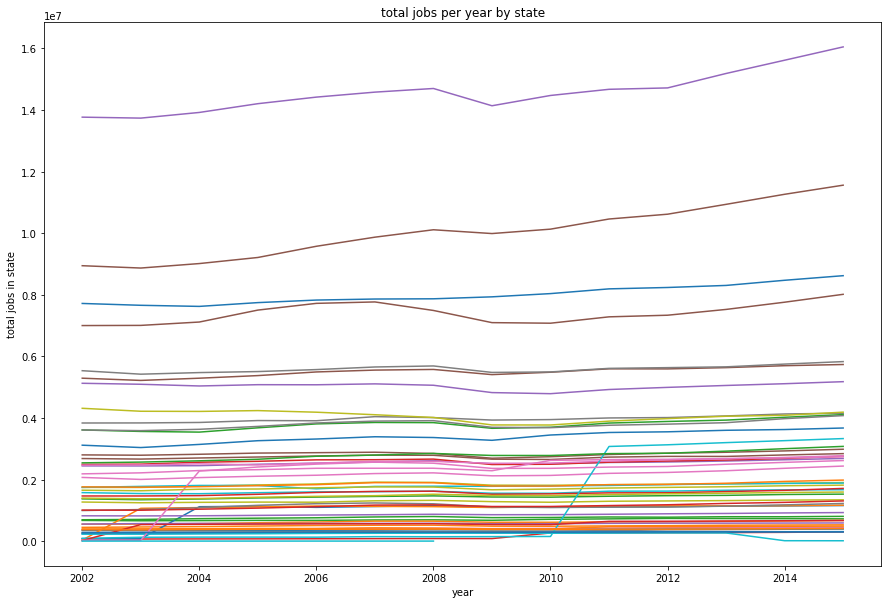

In [51]:
ax = rac_state_df.T.plot(legend=False, figsize=(15,10))
_ = ax.set_xlabel("year")
_ = ax.set_ylabel("total jobs in state")
_ = ax.set_title('total jobs per year by state')

### Analysis: How do age and earnings affect distance and time traveled for work in California?

Regression equation 1:  
dist = b0 + b1&ast;sa02_pct + b2&ast;sa03_pct + b3&ast;se02_pct + b4&ast;se03_pct + b5&ast;sa02&ast;se02 + b6&ast;sa02&ast;se03 + b7&ast;sa03&ast;se02 + b8&ast;sa03&ast;se03 + error  

Regression equation 2:  
minutes = b0 + b1&ast;sa02_pct + b2&ast;sa03_pct + b3&ast;se02_pct + b4&ast;se03_pct + b5&ast;sa02&ast;se02 + b6&ast;sa02&ast;se03 + b7&ast;sa03&ast;se02 + b8&ast;sa03&ast;se03 + error  

Regressors:
sa02 = % of jobs for workers age 30 to 54  
sa03 = % of jobs for workers age 55 or older  
se02 = % of jobs with earnings 1251/month to 3333/month  
se03 = % of jobs with earnings greater than 3333/month  
Interaction terms between age and earnings

Note: 
- First category of each group (age an earnings) are left out of equation to serve as baseline
- Filtering data to 2015 so that each origin/destination pair only counts as one observation

This regression explores the relationship between job distribution (by age and earnings) and travel distance by census block. By regressing travel distance on these four variables and their interactions, we can evaluate whether the distribution of age and earnings of jobs in a origin/destination pair has an effect on the estimated travel distance.   

The results show that the relationship is very weak.
R-squared is very low, meaning that very little of the variance in outcome can be explained by regressors.  
RMSE is the standard deviation of the unexplained variance and is in the same units as the outcome variable. It is very high and exceeds the intercept in both regressions. As a result, we cannot make any significant inferences about how age and earnings affect distance and travel time to work.

Execution explanation:  
Storage level = Serialized 1x Replicated  
This regression involved one job: 3 stages, 203 tasks, 16 executors running


Start with regression equation 1, for travel distance

In [52]:
df_ca_15 = df_ca.where('year == 2015')

In [53]:
df_ca_reg = df_ca_15[['miles', 'sa02_pct', 'sa03_pct', 'se02_pct', 'se03_pct']]

In [54]:
# make interaction variables
for sa in ['sa02_pct', 'sa03_pct']:
    for se in ['se02_pct', 'se03_pct']:
        df_ca_reg = df_ca_reg.withColumn(sa+'_'+se, df_ca_reg[sa]*df_ca_reg[se])

In [55]:
# prepare data into required "features" and "label" format for regression
df_ca_reg_vect = df_ca_reg.rdd.map(lambda x: [Vectors.dense(x[1:9]), x[0]]).toDF(['features', 'label'])
df_ca_reg_vect.show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[0.0,0.0,1.0,0.0,...| 16.9|
|[1.0,0.0,0.0,1.0,...| 45.3|
|[1.0,0.0,1.0,0.0,...| 16.3|
|[0.0,1.0,0.0,1.0,...| 16.3|
|[0.0,0.0,0.0,0.0,...| 16.1|
+--------------------+-----+
only showing top 5 rows



In [56]:
# make linear regression object
lr = LinearRegression(featuresCol = 'features', labelCol = 'label')

In [57]:
# fit model to our data
lr_model = lr.fit(df_ca_reg_vect)

In [58]:
# make predictions
predictions = lr_model.transform(df_ca_reg_vect)

In [59]:
# print the coefficients and intercept 
print("Coefficients: %s" % str(lr_model.coefficients))
print("Intercept: %s" % str(lr_model.intercept))

Coefficients: [-5.20069749368,-6.75821022896,-0.624502741377,-2.60083610515,2.36450737604,5.1353691419,2.90806506367,6.16610561017]
Intercept: 28.8845515055


In [60]:
# evaluate results
trainingSummary = lr_model.summary
print("RMSE: {}".format(trainingSummary.rootMeanSquaredError))
print("r2: {}".format(trainingSummary.r2))

RMSE: 35.0107977797
r2: 0.00217250860293


Now try regression equation 2, time traveled

In [61]:
df_ca_reg = df_ca_15[['minutes', 'sa02_pct', 'sa03_pct', 'se02_pct', 'se03_pct']]

In [62]:
# prepare data into required "features" and "label" format for regression

df_ca_reg_vect = df_ca_reg.rdd.map(lambda x: [Vectors.dense(x[1:9]), x[0]]).toDF(['features', 'label'])
df_ca_reg_vect.show(5)

+-----------------+-----+
|         features|label|
+-----------------+-----+
|[0.0,0.0,1.0,0.0]| 24.2|
|[1.0,0.0,0.0,1.0]| 60.8|
|[1.0,0.0,1.0,0.0]| 22.2|
|[0.0,1.0,0.0,1.0]| 22.2|
|[0.0,0.0,0.0,0.0]| 24.9|
+-----------------+-----+
only showing top 5 rows



In [63]:
# make linear regression object
lr = LinearRegression(featuresCol = 'features', labelCol = 'label')

In [64]:
# fit model to our data
lr_model = lr.fit(df_ca_reg_vect)

In [65]:
# make predictions
predictions = lr_model.transform(df_ca_reg_vect)

In [66]:
# print the coefficients and intercept 
print("Coefficients: %s" % str(lr_model.coefficients))
print("Intercept: %s" % str(lr_model.intercept))

Coefficients: [-3.71211382637,-4.69138754015,1.49404738438,2.66253720749]
Intercept: 37.6802550132


In [67]:
# evaluate results
trainingSummary = lr_model.summary
print("RMSE: {}".format(trainingSummary.rootMeanSquaredError))
print("r2: {}".format(trainingSummary.r2))

RMSE: 43.3768570689
r2: 0.00162553820719
